In [43]:
import open3d as o3d
import pymesh
import numpy as np
import scipy.io as scio
import cv2
import math
from collections import deque
import triangle as tr
import matplotlib.pyplot as plt

import os, sys
import multiprocessing
import shutil
import trimesh
from tqdm import tqdm

GAP = 30
GRID_PIXEL = 10
stereo_dataset_path = "/media/mias/UGREEN0/stereo_pothole_datasets/dataset2"

CORNER_LU = 0
CORNER_LD = 1
CORNER_RD = 2
CORNER_RU = 3

def bfs(img, visited, pos, new_label, label_cnt):
    x, y = pos
    if visited[x][y]:
        return False
    
    visited[x][y] = True
    if img[x][y] == 0:
        return False
    
    dq = deque([])
    dq.appendleft((x,y))
    
    L,R,U,D = visited.shape[0], 0, visited.shape[1], 0
    while len(dq) > 0:
        x, y = dq.pop()
        new_label[x][y] = label_cnt * 50
        L = min(L, x)
        R = max(R, x)
        U = min(U, y)
        D = max(D, y)
        
        for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
            nx, ny = x+dx, y+dy
            if nx < 0 or nx >= visited.shape[0] or ny < 0 or ny >= visited.shape[1]:
                continue
            if visited[nx][ny]:
                continue
            visited[nx][ny] = True
            
            if img[nx][ny] != 0:
                dq.appendleft((nx, ny))
            
    return (L,R,U,D)

def pushback_point(vertices, indices, base, cnt, data_points, i, j, border=False):
    p = data_points[i*GRID_PIXEL][j*GRID_PIXEL]
    
    ###### have to filter unknown bad points###########
    if np.any(np.isinf(p)):
        if i > 1:
            p = data_points[(i-1)*GRID_PIXEL][j*GRID_PIXEL] * 2 - data_points[(i-2)*GRID_PIXEL][j*GRID_PIXEL]
    if np.any(np.isinf(p)):
        if j > 1:
            p = data_points[i*GRID_PIXEL][(j-1)*GRID_PIXEL] * 2 - data_points[i*GRID_PIXEL][(j-2)*GRID_PIXEL]
    if np.any(np.isinf(p)):
        if i > 1 and j > 1:
            p = data_points[(i-1)*GRID_PIXEL][(j+1)*GRID_PIXEL] * 2 - data_points[(i-2)*GRID_PIXEL][(j+2)*GRID_PIXEL]
    if np.any(np.isinf(p)):
        if i > 1 and j < data_points.shape[1] // GRID_PIXEL - 1:
            p = data_points[(i-1)*GRID_PIXEL][(j-1)*GRID_PIXEL] * 2 - data_points[(i-2)*GRID_PIXEL][(j-2)*GRID_PIXEL]
#    if np.any(np.isinf(p)):
##        if i > 3 and j < data_points.shape[1] // GRID_PIXEL - 3:
#        p = data_points[(i-2)*GRID_PIXEL][(j-2)*GRID_PIXEL] * 2 - data_points[(i-4)*GRID_PIXEL][(j-4)*GRID_PIXEL]
    if np.any(np.isinf(p)):
#        print("bad point inf detected at: ", i*GRID_PIXEL, j*GRID_PIXEL)
        return
    ###################################################       
    vertices.append([p[0]-base[0], p[1]-base[1], -p[2]+base[2]])

    if i not in indices:
        indices[i] = {}
    indices[i][j] = cnt


In [2]:
file = "15.mat"
# for file in os.listdir(os.path.join(stereo_dataset_path, "ptcloud")):

filepath = os.path.join(stereo_dataset_path, "ptcloud", file) 
labelpath = os.path.join(stereo_dataset_path, "label", file.split('.')[0]+".png")

data_points = scio.loadmat(filepath)['xyzPoints']

img = cv2.imread(labelpath)
label = img[:,:,2]

visited = np.zeros(label.shape)
new_label = np.zeros(label.shape)
label_cnt = 0
for pi in range(label.shape[0]):
    for pj in range(label.shape[1]):
        result = bfs(label, visited, (pi,pj), new_label, label_cnt)
        if not result:
            continue
    
        L = max(result[0] - GAP, 0)//GRID_PIXEL
        R = min(result[1] + GAP, label.shape[0]-1)//GRID_PIXEL
        U = max(result[2] - GAP, 0)//GRID_PIXEL
        D = min(result[3] + GAP, label.shape[1]-1)//GRID_PIXEL        
                       
        name = stereo_dataset_path[-1] + '_' + file.split('.')[0]+"_"+str(label_cnt)
    
        break

In [3]:
name = stereo_dataset_path[-1] + '_' + file.split('.')[0]+"_"+str(label_cnt)
print("processing mesh", name)
base = data_points[(L+1)*GRID_PIXEL][(U+1)*GRID_PIXEL]

### vertices
vertices = []
indices = {}

#### construct corners.
pushback_point(vertices, indices, base, 0, data_points, L, U)
pushback_point(vertices, indices, base, 1, data_points, L, D)
pushback_point(vertices, indices, base, 2, data_points, R, D)
pushback_point(vertices, indices, base, 3, data_points, R, U)

#### construct vertices
cnt = 4
for i in range(L+1, R):
    for j in range(U+1, D):
        pushback_point(vertices, indices, base, cnt, data_points, i, j)
        cnt += 1


faces = []
for i in range(L+1, R-1):
    for j in range(U+1, D-1):
        flag = False
        if j not in indices[i]:
            continue

        ax, ay = i+1, j+1
        bx, by = i+1, j
        cx, cy = i, j+1

        if ay in indices[ax] and by in indices[bx]:
            faces.append( [ indices[i][j], indices[ax][ay], indices[bx][by] ] )
        if ay in indices[ax] and cy in indices[cx]:
            faces.append( [ indices[i][j], indices[cx][cy], indices[ax][ay] ] )

faces.append([indices[L][U], indices[L][D], indices[L+1][D-1]])
faces.append([indices[L][U], indices[L+1][D-1], indices[L+1][U+1]])
faces.append([indices[L][U], indices[L+1][U+1], indices[R-1][U+1]])
faces.append([indices[L][U], indices[R-1][U+1], indices[R][U]])

faces.append([indices[R][D], indices[R][U], indices[R-1][U+1]])
faces.append([indices[R][D], indices[R-1][U+1], indices[R-1][D-1]])
faces.append([indices[R][D], indices[R-1][D-1], indices[L+1][D-1]])
faces.append([indices[R][D], indices[L+1][D-1], indices[L][D]])

vertices = np.array(vertices) / 100
faces = np.array(faces)

mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices)
mesh.triangles = o3d.utility.Vector3iVector(faces)


coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=60, origin=[0,0,0])
mesh_edges = np.vstack((faces[:, [0, 1]], faces[:, [1, 2]], faces[:, [2, 0]]))

corner0 = mesh.vertices[indices[R][U]] - mesh.vertices[indices[L][U]]
roll = np.arctan2(corner0[2], corner0[1])

corner1 = mesh.vertices[indices[L][D]] - mesh.vertices[indices[L][U]]
pitch = np.arctan2(corner1[2], corner1[0])

Rot = mesh.get_rotation_matrix_from_xyz((-roll, pitch, 0))
mesh.rotate(Rot, center=(0, 0, 0))


processing mesh 2_15_0


TriangleMesh with 1500 points and 2846 triangles.

In [4]:
# o3d.visualization.draw_geometries([mesh])


In [5]:
### z
for i in range(L+1, R):
    a = mesh.vertices[indices[ i ][ U+1 ]][2]
    b = mesh.vertices[indices[ i ][ D-1 ]][2]
    for j in range(U+1, D):
        mesh.vertices[indices[ i ][ j ]][2] -= (a + (b-a) / (D-U-1) * (j-U-1))
        
for j in range(U+1, D):
    c = mesh.vertices[indices[ L+1 ][ j ]][2]
    d = mesh.vertices[indices[ R-1 ][ j ]][2]    
    for i in range(L+1, R):
        mesh.vertices[indices[ i ][ j ]][2] -= (c + (d-c) / (R-L-1) * (i-L-1))

mesh.vertices[0][2] = 0
mesh.vertices[1][2] = 0
mesh.vertices[2][2] = 0
mesh.vertices[3][2] = 0

        
# ### xy
for i in range(L+1, R): #U
    start = mesh.vertices[indices[ L+1 ][ U+1 ]][:2]
    end   = mesh.vertices[indices[ R-1 ][ U+1 ]][:2]
    mesh.vertices[indices[ i ][ U+1 ]][:2] = start + (end - start) / (R-L-2) * (i-L-1)
    
for i in range(L+1, R): #D
    start = mesh.vertices[indices[ L+1 ][ D-1 ]][:2]
    end   = mesh.vertices[indices[ R-1 ][ D-1 ]][:2]
    mesh.vertices[indices[ i ][ D-1 ]][:2] = start + (end - start) / (R-L-2) * (i-L-1)
        
for j in range(U+1, D): #L
    start = mesh.vertices[indices[ L+1 ][ U+1 ]][:2]
    end   = mesh.vertices[indices[ L+1 ][ D-1 ]][:2]
    mesh.vertices[indices[ L+1 ][ j ]][:2] = start + (end - start) / (D-U-2) * (j-U-1)

for j in range(U+1, D): #R
    start = mesh.vertices[indices[ R-1 ][ U+1 ]][:2]
    end   = mesh.vertices[indices[ R-1 ][ D-1 ]][:2]
    mesh.vertices[indices[ R-1 ][ j ]][:2] = start + (end - start) / (D-U-2) * (j-U-1)
    

In [6]:
# mesh_r = copy.deepcopy(mesh)

coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0,0,0])

triangles = np.asarray(mesh.triangles)
mesh_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))

mesh_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(mesh.vertices),
    lines=o3d.utility.Vector2iVector(mesh_edges),
)
o3d.visualization.draw_geometries([mesh, coord, mesh_lines])
# o3d.io.write_triangle_mesh(file.split(".")[0] + ".ply", mesh)


In [7]:
################################### Pit Mesh Above ############################################


In [8]:
################################### Road Mesh Below ############################################
mesh.translate((1.8,10.984,0))
Rot = mesh.get_rotation_matrix_from_xyz((0, 0, 2.725))
mesh.rotate(Rot, center=mesh.get_center())

triangles = np.asarray(mesh.triangles)
mesh_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))

mesh_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(mesh.vertices),
    lines=o3d.utility.Vector2iVector(mesh_edges),
)

In [9]:
coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0,0,0])

road = o3d.io.read_triangle_mesh("/home/mias/Datasets/CarlaRoads/Town01_Road_Road.obj")
road.vertices = o3d.utility.Vector3dVector(np.array(road.vertices)[:, [2,0,1]] / 100)

triangles = np.asarray(road.triangles)
road_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))

road_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(road.vertices),
    lines=o3d.utility.Vector2iVector(road_edges),
)
o3d.visualization.draw_geometries([mesh, mesh_lines, road, road_lines, coord])

In [10]:
# np.array(road.vertices)[:, [0,2,1]]
np.array(mesh.vertices)

array([[ 3.08550157e+00,  1.15846060e+01,  0.00000000e+00],
       [ 2.01482383e+00,  1.20696775e+01,  0.00000000e+00],
       [ 1.70659081e+00,  1.12499641e+01,  0.00000000e+00],
       ...,
       [ 1.77873982e+00,  1.12402330e+01, -6.03111754e-05],
       [ 1.75679345e+00,  1.12512506e+01, -4.48065899e-05],
       [ 1.73484707e+00,  1.12622682e+01, -4.91897904e-05]])

In [11]:
np.array(road.vertices)

array([[ 2.74987744e+01,  1.20899998e-03, -0.00000000e+00],
       [ 2.87313330e+01, -3.94950806e+00,  0.00000000e+00],
       [ 2.87313232e+01,  1.20899998e-03, -0.00000000e+00],
       ...,
       [ 5.74924707e+01,  1.44199717e+02, -0.00000000e+00],
       [ 5.35444434e+01,  1.46586914e+02, -0.00000000e+00],
       [ 5.74951025e+01,  1.46582510e+02, -0.00000000e+00]])

In [12]:


scene = o3d.t.geometry.RaycastingScene()
road_tri = o3d.t.geometry.TriangleMesh.from_legacy(road)
road_id = scene.add_triangles(road_tri)

quires = []
for v in np.array(mesh.vertices):
    quires.append([v[0], v[1], v[2] + 10, 0, 0, -1])
rays = o3d.core.Tensor(quires, dtype=o3d.core.Dtype.Float32)

ans = scene.cast_rays(rays)

collide = list(set(ans['primitive_ids'].numpy()))
if scene.INVALID_ID in collide:
    print("outside of boundary!")

border = []
for c in collide:
        
    for i,j in [[0,1], [1,2], [2,0]]:
        s = min(road.triangles[c][i], road.triangles[c][j])
        e = max(road.triangles[c][i], road.triangles[c][j])
        if (s, e) in border:
            border.remove((s,e))
        else:
            border.append((s,e))

border_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(road.vertices),
    lines=o3d.utility.Vector2iVector(np.array(border)),
)
road.triangles = o3d.utility.Vector3iVector(np.delete(np.asarray(road.triangles), collide, axis=0))


In [13]:
o3d.visualization.draw_geometries([mesh, coord, mesh_lines, road, border_lines])


In [14]:
# q_pts

In [15]:
# B['vertices']

In [16]:
all_verts = np.vstack([road.vertices, mesh.vertices])

offset = np.array(road.vertices).shape[0]
tmp_id = np.array([ [indices[L][U], indices[L][D]], 
                    [indices[L][D], indices[R][D]],
                    [indices[R][D], indices[R][U]], 
                    [indices[R][U], indices[L][U]]
                  ])
border_edge_id = np.vstack([border, tmp_id+offset])



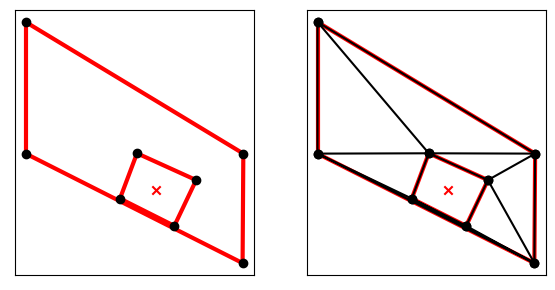

<Figure size 2000x2000 with 0 Axes>

In [17]:
origin_idx = list(set(border_edge_id.flatten().tolist()))
query_idx = {origin_idx[i]:i for i in range(len(origin_idx))}

q_pts = []
q_seg = []

for i in origin_idx:
    q_pts.append(all_verts[i][:2])
q_pts = np.array(q_pts)

for bd in border_edge_id:
    q_seg.append([query_idx[bd[0]], query_idx[bd[1]]])
q_seg = np.array(q_seg)

A = dict(vertices=q_pts, segments=q_seg, holes=[mesh_lines.get_center()[:2]])
B = tr.triangulate(A, 'p')
tr.compare(plt, A, B)
plt.figure(figsize=(20,20))

plt.show()

In [18]:
tmp_id = np.vstack((B['triangles'][:, [0, 1]], B['triangles'][:, [1, 2]], B['triangles'][:, [2, 0]]))
delaunay_edges = np.array(origin_idx)[tmp_id]


In [19]:
tmp_id = np.vstack((B['triangles'][:, [0, 1]], B['triangles'][:, [1, 2]], B['triangles'][:, [2, 0]]))
delaunay_edges = np.array(origin_idx)[tmp_id]

delaunay_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector( all_verts ),
    lines=o3d.utility.Vector2iVector( delaunay_edges ),
)

In [20]:
border_edge_id

array([[15557, 15558],
       [15556, 15557],
       [15556, 15560],
       [15558, 15560],
       [19724, 19725],
       [19725, 19726],
       [19726, 19727],
       [19727, 19724]])

In [21]:
o3d.visualization.draw_geometries([mesh, coord, mesh_lines, road, delaunay_lines])


In [22]:
new_road = o3d.geometry.TriangleMesh()
new_road.vertices = o3d.utility.Vector3dVector(all_verts)

new_tris = np.vstack([road.triangles, np.array(mesh.triangles) + offset, np.array(origin_idx)[np.array(B['triangles'])]])
new_road.triangles = o3d.utility.Vector3iVector(new_tris)

triangles = np.asarray(new_road.triangles)
new_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))
new_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(new_road.vertices),
    lines=o3d.utility.Vector2iVector(new_edges),
)
o3d.visualization.draw_geometries([new_road, coord, new_lines])


In [23]:
o3d.io.write_triangle_mesh("new_road.ply", new_road)


True

In [24]:
import sys
CUR_PATH = os.getcwd()
FOLDER_PATH = os.path.join(CUR_PATH, "RoadPitMesh")
PIT_LIST = os.listdir(os.path.join(CUR_PATH, "PitMesh")) 
# PIT_LIST
road.triangles

std::vector<Eigen::Vector3i> with 24498 elements.
Use numpy.asarray() to access data.

In [25]:
# import matplotlib.pyplot as plt
# import numpy as np

# import triangle as tr


# def circle(N, R):
#     i = np.arange(N)
#     theta = i * 2 * np.pi / N
#     pts = np.stack([np.cos(theta), np.sin(theta)], axis=1) * R
#     seg = np.stack([i, i + 1], axis=1) % N
#     return pts, seg


# pts0, seg0 = circle(30, 1.4)
# pts1, seg1 = circle(16, 0.6)
# pts = np.vstack([pts0, pts1])
# seg = np.vstack([seg0, seg1 + seg0.shape[0]])

# A = dict(vertices=pts, segments=seg, holes=[[0, 0]])
# B = tr.triangulate(A, 'qpa0.05')
# tr.compare(plt, A, B)
# plt.show()

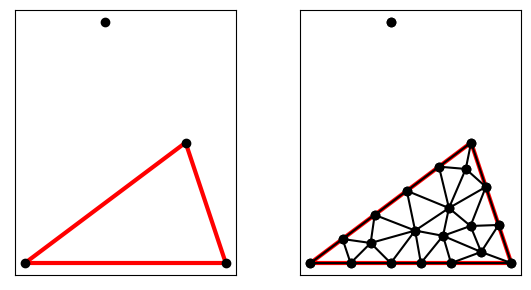

In [26]:
import matplotlib.pyplot as plt
import numpy as np

import triangle as tr


pts = np.array([[0,0], [5,0], [4,3], [2,6]])
seg = np.array([[0,1],[1,2],[2,0]])

A = dict(vertices=pts, segments=seg)
B = tr.triangulate(A, 'qpa0.5')
tr.compare(plt, A, B)
plt.show()

In [27]:
B

{'vertices': array([[0.        , 0.        ],
        [5.        , 0.        ],
        [4.        , 3.        ],
        [2.        , 6.        ],
        [2.4       , 1.8       ],
        [2.        , 0.        ],
        [3.5       , 0.        ],
        [4.36754447, 1.8973666 ],
        [3.2       , 2.4       ],
        [3.86754447, 2.34327404],
        [3.4486833 , 1.37032032],
        [2.60658865, 0.80964697],
        [4.68377223, 0.9486833 ],
        [2.75      , 0.        ],
        [3.30148074, 0.67868674],
        [4.25      , 0.27704628],
        [3.98570599, 0.92363173],
        [0.8       , 0.6       ],
        [1.        , 0.        ],
        [1.6       , 1.2       ],
        [1.5       , 0.5       ]]),
 'vertex_markers': array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
       

In [28]:
np.concatenate

<function numpy.concatenate>

In [48]:
road = o3d.io.read_triangle_mesh("/home/mias/Datasets/CarlaRoads/Town01_Road_Road.obj")
road.remove_duplicated_vertices()
road.vertices = o3d.utility.Vector3dVector(np.array(road.vertices)[:, [2,0,1]] / 100)

triangles = np.asarray(road.triangles)
road_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))


mesh = o3d.geometry.TriangleMesh()


Xs = np.array(road.vertices)[:,0]
Ys = np.array(road.vertices)[:,1]
RoadBoundary = [Xs.min(), Xs.max(), Ys.min(), Ys.max()]

In [30]:
generated = 0
CUR_PATH = os.path.dirname(os.path.curdir)
PIT_LIST = os.listdir(os.path.join(CUR_PATH, "PitMesh")) 

collision_manager = trimesh.collision.CollisionManager()
new_road = o3d.geometry.TriangleMesh()


In [31]:
RoadBoundary

[-4.093587951660156, 332.698046875, -4.093587036132813, 398.41890625]

In [32]:
for i in range(10) :
    new_road.clear()
    mesh.clear()

    pit_name = PIT_LIST[np.random.randint(len(PIT_LIST))]
#     pit_name = "2_39_0.ply"
    print("lp", pit_name)
    # for pit_name, (x,y,yaw) in [["2_23_0.ply", (7.837738336454764, 2.402143199257104, 0.5382318404417871)],
    #  ["2_08_0.ply", (2.244315337618926, -5.715035545233631, 2.1133360462766233)]]:

    new_road = o3d.geometry.TriangleMesh(road)
    # new_road = o3d.geometry.TriangleMesh()
    # new_road.vertices = o3d.utility.Vector3dVector(np.array(road.vertices))
    # new_road.triangles = o3d.utility.Vector3iVector(np.array(road.triangles))

    x = np.random.uniform(RoadBoundary[0], RoadBoundary[1])
    y = np.random.uniform(RoadBoundary[2], RoadBoundary[3])
    yaw = np.random.uniform() * np.pi
#     x = 29.347967778266245
#     y = 392.47474833888293
#     yaw = 0.3696402171284399

    print("  x", x)
    print("  y", y)
    print("  yaw", yaw)

    mesh = o3d.io.read_triangle_mesh(os.path.join(CUR_PATH, "PitMesh", pit_name))

    mesh.translate((x, y, 0))
    Rot = mesh.get_rotation_matrix_from_xyz((0, 0, yaw))
    mesh.rotate(Rot, center=mesh.get_center())

    test0 = trimesh.base.Trimesh(vertices=np.array(mesh.vertices)[:4], faces=np.array([[CORNER_LU, CORNER_LD, CORNER_RD], [CORNER_LU, CORNER_RD, CORNER_RU]]))

    collision_manager.add_object(str(generated), test0)
    if collision_manager.in_collision_internal():
        collision_manager.remove_object(str(generated))
        print("collision")
        continue

    triangles = np.asarray(mesh.triangles)
    mesh_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))

    mesh_lines = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(mesh.vertices),
        lines=o3d.utility.Vector2iVector(mesh_edges),
    )

    quires = []
    for v in np.array(mesh.vertices):
        quires.append([v[0], v[1], v[2] + 1000, 0, 0, -1])
    rays = o3d.core.Tensor(quires, dtype=o3d.core.Dtype.Float32)

    scene = o3d.t.geometry.RaycastingScene()
    road_tri = o3d.t.geometry.TriangleMesh.from_legacy(new_road)
    road_id = scene.add_triangles(road_tri)

    ans = scene.cast_rays(rays)

    collide = list(set(ans['primitive_ids'].numpy()))
    if scene.INVALID_ID in collide:
        print("outside of map!")
        continue

    border = []
    visited = set([])
    for c in collide:
        for i,j in [[0,1], [1,2], [2,0]]:
            s = min(new_road.triangles[c][i], new_road.triangles[c][j])
            e = max(new_road.triangles[c][i], new_road.triangles[c][j])
            if (s,e) in visited:
                border.remove((s,e))
#                 print("rmv", s, e)
            else:
                visited.add((s,e))
                border.append((s,e))
#                 print('Add', s, e)
    border_lines = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(new_road.vertices),
        lines=o3d.utility.Vector2iVector(np.array(border)),
    )
#     break


lp 2_14_0.ply
  x 159.12020582691486
  y 167.95214523752531
  yaw 0.8971005149325987
outside of map!
lp 2_04_0.ply
  x 101.72818584191052
  y 390.4132897548547
  yaw 0.05022553324861749
lp 2_26_0.ply
  x 73.0159016852982
  y 102.33679907383957
  yaw 1.4691836236874183
outside of map!
lp 2_01_0.ply
  x 136.89285074281395
  y 80.23843161826876
  yaw 1.8458116401465277
outside of map!
lp 2_07_0.ply
  x 225.04507557926445
  y 14.795282323500846
  yaw 2.6858613527995505
outside of map!
lp 2_18_0.ply
  x 30.521809842201172
  y 358.1853944672879
  yaw 2.4701136990714345
outside of map!
lp 2_35_0.ply
  x 80.68182742696956
  y 160.90549284410392
  yaw 0.15285666558639086
outside of map!
lp 2_08_0.ply
  x 236.1021053330669
  y 361.1733209902934
  yaw 1.9786606833591747
outside of map!
lp 2_20_0.ply
  x 161.13876875083255
  y 324.28739166319986
  yaw 2.532265015682447
outside of map!
lp 2_19_0.ply
  x 10.51984801660273
  y 131.14084626068
  yaw 1.0734764211392729
outside of map!


In [33]:
# pts = set([])
# for v in visited:
#     pts.add(v[0])
#     pts.add(v[1])
    
# pts = list(pts)
# for i in range(len(pts)):
#     for j in range(i+1, len(pts)):
#         print(pts[i], pts[j], np.linalg.norm(new_road.vertices[pts[i]] - new_road.vertices[pts[j]]))


In [34]:
"""lp 2_39_0.ply
x 29.347967778266245
y 392.47474833888293
yaw 0.3696402171284399"""
border

[(2613, 2614),
 (2612, 2614),
 (2612, 2615),
 (2615, 2617),
 (2613, 2617),
 (2690, 2691),
 (2689, 2691),
 (2689, 2690)]

In [35]:

print(  "triangles before", new_road.triangles )
new_road.triangles = o3d.utility.Vector3iVector(np.delete(np.asarray(new_road.triangles), collide, axis=0))
print(  "triangle after", new_road.triangles )


triangles before std::vector<Eigen::Vector3i> with 24500 elements.
Use numpy.asarray() to access data.


IndexError: index 4294967295 is out of bounds for axis 0 with size 24500

In [ ]:
all_verts = np.vstack([new_road.vertices, mesh.vertices])

offset = np.array(new_road.vertices).shape[0]
tmp_id = np.array([ [CORNER_LU, CORNER_LD], 
                    [CORNER_LD, CORNER_RD],
                    [CORNER_RD, CORNER_RU], 
                    [CORNER_RU, CORNER_LU]
                ])
border_edge_id = np.vstack([border, tmp_id+offset])



In [ ]:
origin_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector( all_verts ),
    lines=o3d.utility.Vector2iVector( border_edge_id ),
)

coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3, origin=mesh.get_center())

o3d.visualization.draw_geometries([road, mesh_lines, border_lines, coord])

In [ ]:
#### triangles solution: Delaunary triangulation
origin_idx = list(set(border_edge_id.flatten().tolist()))
query_idx = {origin_idx[i]:i for i in range(len(origin_idx))}

q_pts = []
q_seg = []

for i in origin_idx:
    q_pts.append(all_verts[i][:2])
q_pts = np.array(q_pts)

for bd in border_edge_id:
    q_seg.append([query_idx[bd[0]], query_idx[bd[1]]])
q_seg = np.array(q_seg)

In [ ]:
q_pts

In [ ]:
o3d.visualization.draw_geometries([mesh, mesh_lines])

In [ ]:


A = dict(vertices=q_pts, segments=q_seg, holes=[mesh.get_center()[:2]]) ## [0,0] should work
B = tr.triangulate(A, 'piC')
tr.compare(plt, A, B)


tmp_id = np.vstack((B['triangles'][:, [0, 1]], B['triangles'][:, [1, 2]], B['triangles'][:, [2, 0]]))
# print("origin idx:", origin_idx)
# print("A: \n", A)
# print("B: \n", B)
if A['vertices'].shape[0] != B['vertices'].shape[0]:
    print("Vertices number mismatch")
#     continue

In [ ]:

delaunay_edges = np.array(origin_idx)[tmp_id]

delaunay_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector( all_verts ),
    lines=o3d.utility.Vector2iVector( delaunay_edges ),
)


# new_road = o3d.geometry.TriangleMesh()
new_road.vertices = o3d.utility.Vector3dVector(all_verts)

new_tris = np.vstack([new_road.triangles, np.array(mesh.triangles) + offset, np.array(origin_idx)[np.array(B['triangles'])]])
new_road.triangles = o3d.utility.Vector3iVector(new_tris)

triangles = np.asarray(new_road.triangles)
new_edges = np.vstack((triangles[:, [0, 1]], triangles[:, [1, 2]], triangles[:, [2, 0]]))
#     new_lines = o3d.geometry.LineSet(
#         points=o3d.utility.Vector3dVector(new_road.vertices),
#         lines=o3d.utility.Vector2iVector(new_edges),
#     )
# o3d.visualization.draw_geometries([road, new_lines])
road.clear()
road = o3d.geometry.TriangleMesh(new_road)
mesh.clear()

generated += 1
print("Successfully generated", pit_name, "at", x, y, yaw)

In [ ]:
o3d.visualization.draw_geometries([road, road_lines, coord])

In [36]:
def tri_area(v1, v2, v3):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    a = np.linalg.norm(v2 - v1)
    b = np.linalg.norm(v3 - v2)
    c = np.linalg.norm(v1 - v3)
    s = (a + b + c) / 2
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

In [37]:
global_tris = np.array(road.vertices)[np.array(road.triangles)]
for tri in global_tris:
    area = tri_area(tri[0], tri[1], tri[2])
    print(area)

2.434725839193456
2.4455002094497473
2.2716580086072944
0.0457764126494526
0.030521071677654894
0.030521071677654894
0.0457764126494526
0.028351373457163688
2.271652613711074
2.2716670816687405
0.04252223461419326
0.04252223461419326
0.028351373457163685
2.271666799814255
0.04252241516113293
2.271661979693671
0.02835149383544918
0.04252066040039064
0.02834868621826162
0.02834856585189692
2.2716531510614293
0.04252047986090142
2.2716579709965754
0.028348390376567466
0.04252118176221847
0.028348450559377483
2.2716629199434104
2.2716581006094194
0.04252136230468739
0.02834851074218747
0.04252066040039064
0.028348631107807068
2.271667745917344
2.4347506096463243
2.4239906578525745
0.042520750670134985
0.04252075067013498
0.02834857092499708
0.045371920546889453
0.030249444973468636
0.045372482275217896
0.030249632216244972
0.07106811180710777
2.4256186349765767
2.253176417158977
0.07650592053085571
2.2531907674128844
2.253176414431881
0.07650648724697533
0.0102972318939866
0.01029723189398

In [ ]:
360/2500

In [ ]:
np.concatenate([old_verts, new_verts])

In [ ]:
# small_pieces

In [38]:
verts = np.array(road.vertices)
tris = np.array(road.triangles)

In [55]:
np.concatenate([old_verts, new_verts]).shape

(1062438, 3)

In [62]:
threshold_split = 0.5
verts = np.array(road.vertices)
tris = np.array(road.triangles)
print("verts ", verts.shape[0], " tris ", tris.shape[0])

tri_coord = verts[tris]
small_pieces = []
large_pieces = []
for i in tqdm(range(tri_coord.shape[0])):
    tri = tri_coord[i]
    area = tri_area(tri[0], tri[1], tri[2])
    if area < threshold_split:
        small_pieces.append(tris[i])
    else:
        large_pieces.append(tris[i])

# pbar = tqdm(total=len(large_pieces))
for _i in tqdm(range(len(large_pieces))):
#     pbar.update()
    new_road = o3d.geometry.TriangleMesh()
    
    tri_to_split_id = large_pieces[_i]
    q_pts = verts[tri_to_split_id][:,:2]
    q_seg = np.array([[0,1],[1,2],[2,0]])

    A = dict(vertices=q_pts, segments=q_seg)
    #     s = 'qpa'+str(threshold_split)
    B = tr.triangulate(A, 'qpa0.005')
    
    offset = np.array(road.vertices).shape[0]

    old_verts = np.array(road.vertices)
    new_verts = np.concatenate([np.array(B['vertices']), np.zeros([B['vertices'].shape[0], 1])], axis=1)
    new_road.vertices = o3d.utility.Vector3dVector(np.concatenate([old_verts, new_verts]))

    old_faces = np.array(road.triangles)
    new_faces = offset + B['triangles']
    faces = np.concatenate([old_faces, new_faces])
    new_road.triangles = o3d.utility.Vector3iVector(faces)
    
    road = o3d.geometry.TriangleMesh()
    road.vertices = new_road.vertices
    road.triangles = new_road.triangles
    
    new_road.clear()

verts  438089  tris  1569335


100%|█████████████████████████████████████████████████████████████| 8872/8872 [18:40<00:00,  7.92it/s]


In [63]:
print("verts ", np.array(road.vertices).shape[0], " tris ", np.array(road.triangles).shape[0])
# road.remove_duplicated_vertices()
# print("verts ", np.array(road.vertices).shape[0], " tris ", np.array(road.triangles).shape[0])


verts  4567134  tris  9084529


In [64]:
road_lines = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(road.vertices),
    lines=o3d.utility.Vector2iVector(road_edges),
)

In [65]:
o3d.visualization.draw_geometries([road, road_lines, coord])

In [ ]:
# A = np.array([0,0])
# B = np.array([5,3])
# C = np.array([3,2])

# n = (B-A) / np.linalg.norm(B-A)
# A + np.dot((C-A), n) * n

In [92]:
import noise
import numpy as np
from PIL import Image

# Set the size of the heightmap
width = 1024
height = 1024

# Set the scale of the Perlin noise
scale = 50.0

# Generate a 2D grid of Perlin noise values
perlin_grid = np.zeros((width, height))
for x in range(width):
    for y in range(height):
        perlin_grid[x][y] = noise.pnoise2(x /2, y/2 )

# Normalize the grid to the range [0, 1]
# perlin_grid = (perlin_grid - perlin_grid.min()) / (perlin_grid.max() - perlin_grid.min())

# Save the heightmap as an image
img = Image.fromarray(np.uint8(perlin_grid * 255))
img.show()
# plt.imshow(perlin_grid, cmap='hot', interpolation='nearest')
# plt.show()

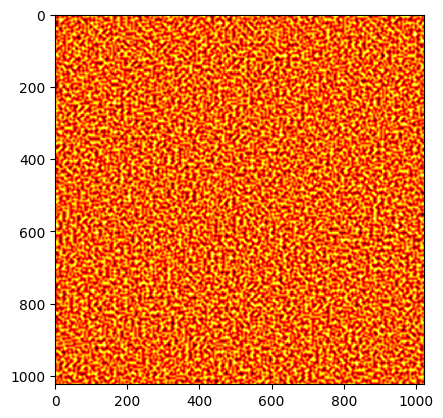

In [79]:
plt.imshow(perlin_grid, cmap='hot', interpolation='nearest')
plt.show()

In [104]:
noise.snoise2(10, -5)

0.00018219133198726922

In [107]:
np.arcsin(1.15/4.5) * 180 / np.pi

14.806506911897516

In [111]:
4.5 * np.sin(15 / 180 * np.pi)

1.1646857029613433